In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# **Load Data**

In [2]:
# Load dataset
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv',
                      index_col='date_time',
                      parse_dates=True,
                      infer_datetime_format=True,
                      na_values=[],           # tidak anggap apapun sebagai NaN
                      keep_default_na=False   # nonaktifkan behavior default-nya
)
traffic

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543
2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781
2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159


# **Exploratory Data Analysis**

In [3]:
# Memeriksa informasi dataset
traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


**Insight**:
- Terdapat 8 variabel, dengan jumlah data sebanyak 48204
- Berikut penjelasan setiap variabel:
  - holiday: hari libur nasional (kategorik)
  - temp: suhu rata-rata dalam satuan Kelvin (numerik)
  - rain_1h: curah hujan/jam dalam satuan mm (numerik)
  - snow_1h: curah salju/jam dalam satuan mm (numerik)
  - clouds_all: persentase tutupan awan (numerik)
  - weather_main: deskripsi cuaca singkat (kategorik)
  - weather_description: deskripsi cuaca lengkap (kategorik)
  - traffic_volume: volume lalu lintas per jam dengan satuan kendaraan (numerik)

In [4]:
# Menampilkan statistika deskriptif dataset
traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


**Insight**:
- Rata-rata suhu selama pencatatan kurang lebih 6 tahun (2012-2018) adalah 281.2 Kelvin, dengan suhu terendah 0 Kelvin dan suhu tertinggi 310.07 Kelvin
- Rata-rata curah hujan perjam selama pencatatan kurang lebih 6 tahun (2012-2018) adalah 0.33 mm/jam, dengan curah hujan terendah 0 mm/jam (tidak terjadi hujan) dan tertinggi 9831.3 mm/jam (sepertinya ada kesalahan karena tidak mungkin mencapai angka tersebut)
- Rata-rata curah salju perjam selama pencatatan kurang lebih 6 tahun (2012-2018) adalah 0.0002 mm/jam, dengan curah salju terendah 0 mm/jam (tidak turun salju) dan tertinggi 0.51 mm/jam
- Rata-rata persentase tutupan awan selama pencatatan kurang lebih 6 tahun (2012-2018) adalah 49.36%, dengan tutupan awan terendah 0% (tidak ada awan) dan tutupan awan tertinggi 100%
- Rata-rata volume lalu lintas perjam selama pencatatan kurang lebih 6 tahun (2012-2018) adalah 3260 kendaraan, dengan volume terendah adalah 0 kendaraan perjam (tidak ada kendaraan) dan tertinggi 7280 kendaraan perjam

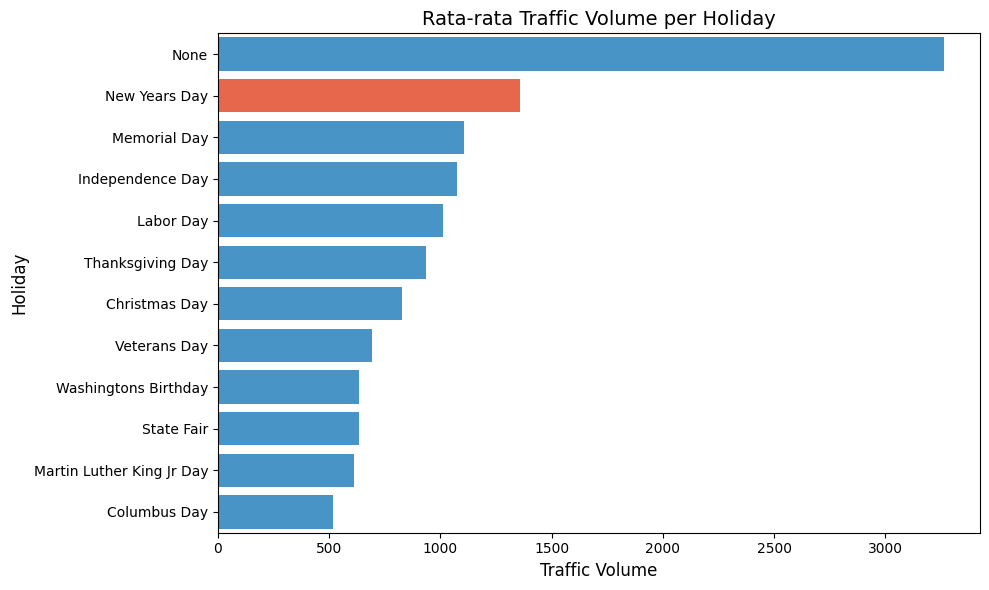

In [5]:
# Menampilkan rata-rata lalu lintas berdasarkan hari libur
plt.figure(figsize=(10, 6))

# Hitung rata-rata traffic volume per holiday
holiday_avg = traffic.groupby('holiday')['traffic_volume'].mean().sort_values(ascending=False)

# Tentukan holiday tertinggi selain 'None'
holiday_excl_none = holiday_avg.drop('None')
top_holiday = holiday_excl_none.idxmax()

colors = ['#FF5733' if holiday == top_holiday else '#3498db' for holiday in holiday_avg.index]

# Horizontal barplot
sns.barplot(y=holiday_avg.index, x=holiday_avg.values, palette=colors)

# Judul dan label
plt.title("Rata-rata Traffic Volume per Holiday", fontsize=14)
plt.xlabel("Traffic Volume", fontsize=12)
plt.ylabel("Holiday", fontsize=12)
plt.tight_layout()
plt.show()

**Insight**:
Rata-rata kepadatan lalu lintas terbanyak terjadi ketika libur Tahun Baru yang mencapai hampir 1500 kendaraan setiap jam

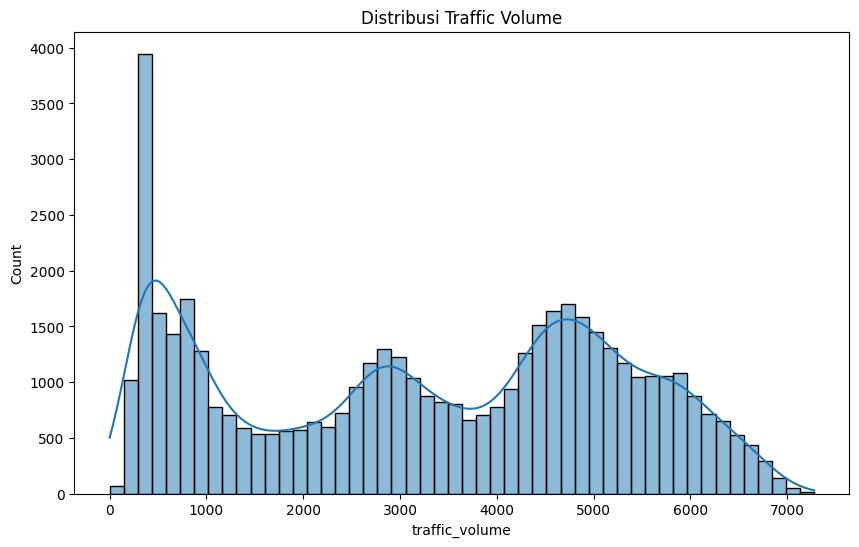

In [6]:
# Menampilkan distribusi volume lalu lintas
plt.figure(figsize=(10, 6))
sns.histplot(traffic['traffic_volume'], bins=50, kde=True)
plt.title('Distribusi Traffic Volume')
plt.show()

**Insight**:
- Distribusi volume lalu lintas bersifat multimodal, dimana terdapat beberapa puncak yang mengindikasikan waktu-waktu tertentu seperti jam sibuk pagi atau sore
- Ada lonjakan besar pada volume < 1000 kendaraan/jam, mungkin terjadi pada malam hari atau hari libur
- Volume lalu lintas tinggi jarang terjadi tetapi tetap ada

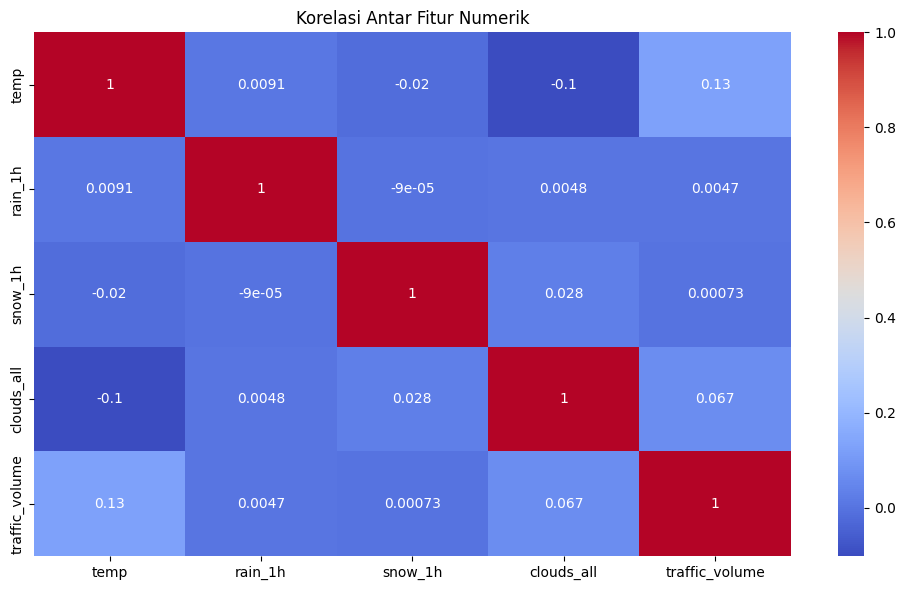

In [7]:
# Heatmap Korelasi antar Fitur Numerik
plt.figure(figsize=(10, 6))
numerical = traffic[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']]
sns.heatmap(numerical.corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi Antar Fitur Numerik")
plt.tight_layout()
plt.show()

**Insight**:
- Korelasi antar fitur numerik sangat lemah terhadap volume lalu lintas (traffic_volume)
- Fitur suhu (temp) memiliki korelasi tertinggi dengan volume lalu lintas, sebesar 0.13 masih sangat lemah
- Curah hujan (rain_1h) dan curah salju (snow_1h) hampir tidak berkorelasi dengan volume lalu lintas
- Hal ini berarti, cuaca tidak terlalu memengaruhi volume lalu lintas, mungkin fitur waktu lebih relevan daripada faktor cuaca

# **Data Preprocessing**

In [8]:
# Time Feature Engineering
traffic['hour'] = traffic.index.hour
traffic['day'] = traffic.index.day
traffic['month'] = traffic.index.month
traffic['year'] = traffic.index.year
traffic['weekday'] = traffic.index.weekday

## **Missing Values**

In [9]:
# Deteksi Missing Values
traffic.isnull().sum()

,0
holiday,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
traffic_volume,0
hour,0
day,0


**Insight**:
Tidak ada missing values

## **Data Duplikat**

In [10]:
# Deteksi Data Duplikat
print("Jumlah duplikasi: ", traffic.duplicated().sum())

Jumlah duplikasi:  17


In [11]:
# Menghapus Data Duplikat
traffic.drop_duplicates(inplace=True)

# Periksa Kembali Data Duplikat
print("Jumlah duplikasi setelah penanganan: ", traffic.duplicated().sum())

Jumlah duplikasi setelah penanganan:  0


## **Outliers**


📊 Column: temp
Outlier count: 10


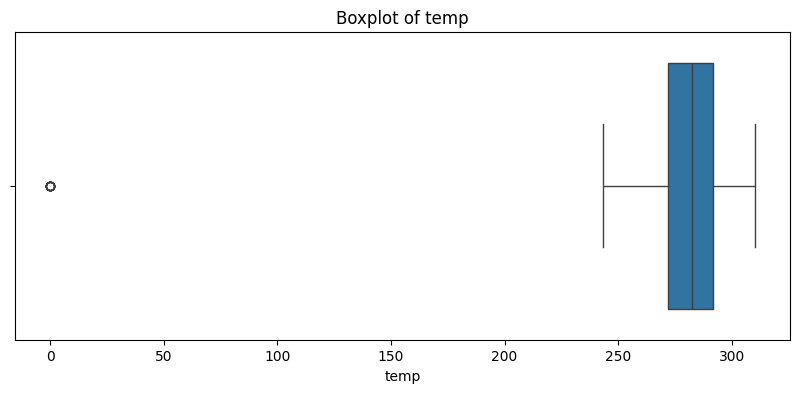


📊 Column: rain_1h
Outlier count: 3467


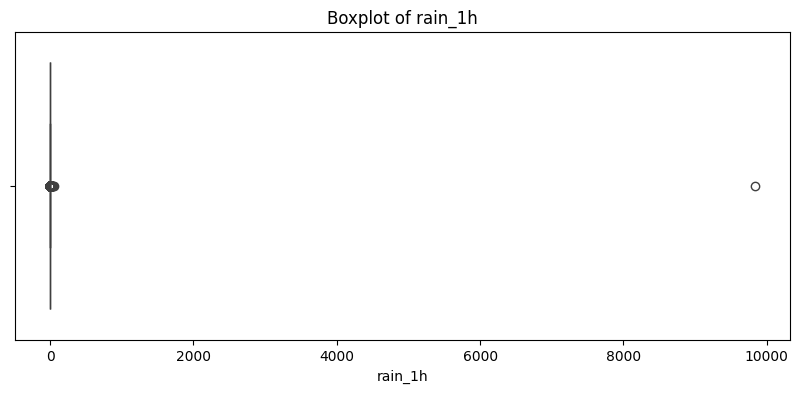


📊 Column: snow_1h
Outlier count: 63


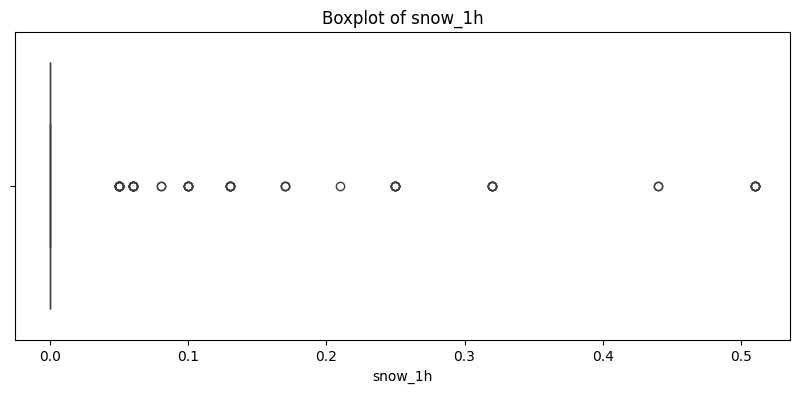


📊 Column: clouds_all
Outlier count: 0


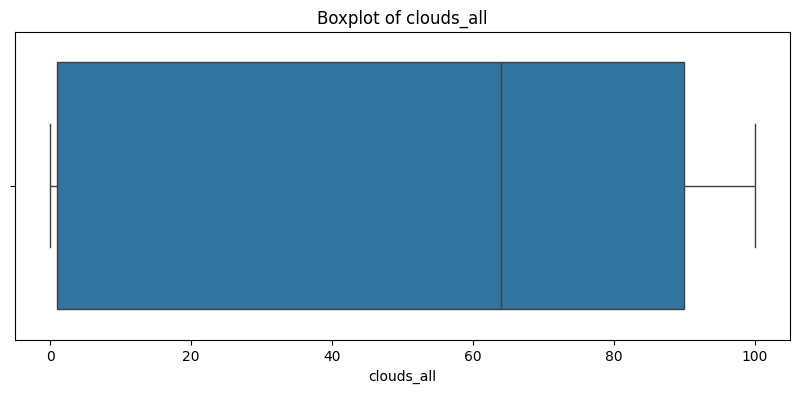


📊 Column: traffic_volume
Outlier count: 0


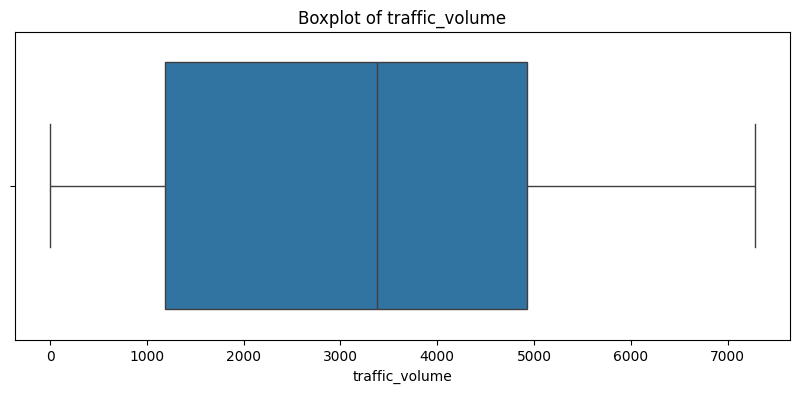


📊 Column: hour
Outlier count: 0


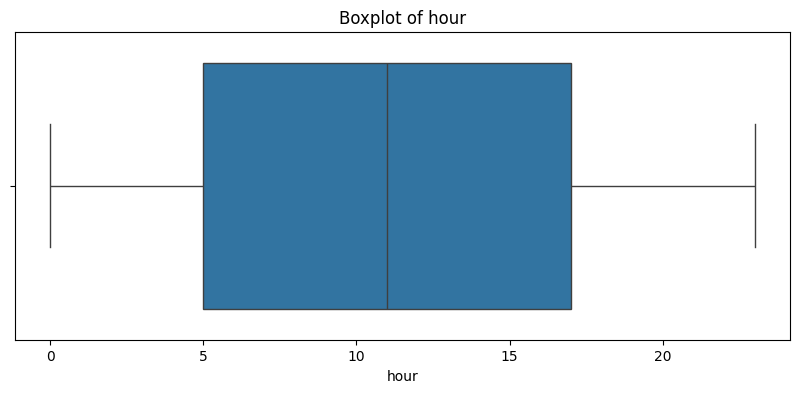


📊 Column: day
Outlier count: 0


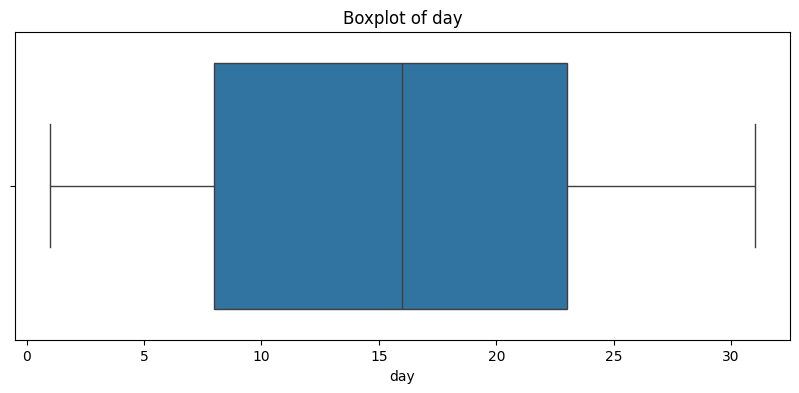


📊 Column: month
Outlier count: 0


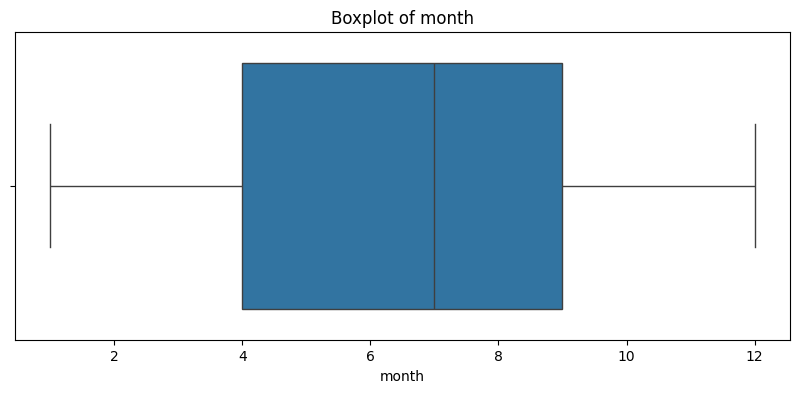


📊 Column: year
Outlier count: 0


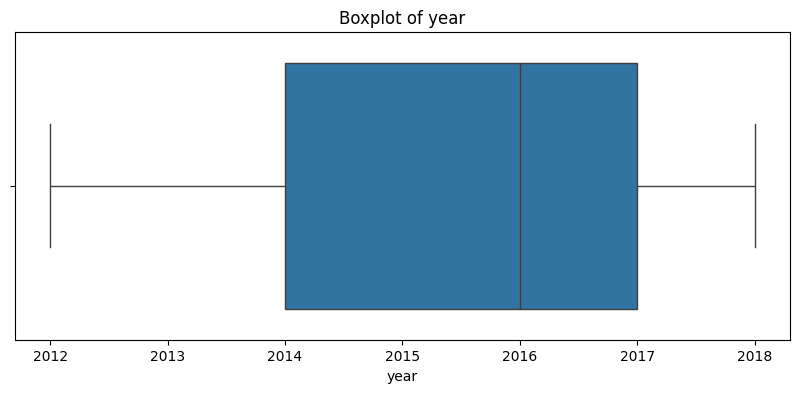


📊 Column: weekday
Outlier count: 0


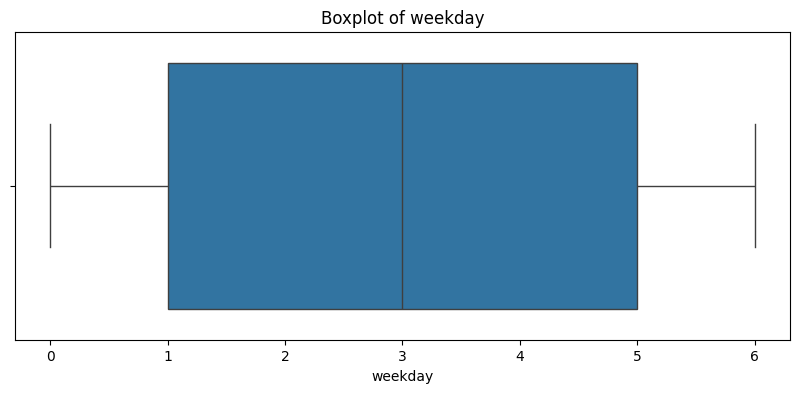

In [12]:
# Pilih semua kolom numerik
num_cols = traffic.select_dtypes(include=['number']).columns

# Loop untuk visualisasi dan deteksi outlier
for col in num_cols:
    Q1 = traffic[col].quantile(0.25)
    Q3 = traffic[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = traffic[(traffic[col] < lower_bound) | (traffic[col] > upper_bound)]

    print(f"\n📊 Column: {col}")
    print(f"Outlier count: {len(outliers)}")

    plt.figure(figsize=(10, 4))
    sns.boxplot(x=traffic[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

**Insight**:
- Terdapat 3 fitur numerik yang memiliki outlier, antara lain:
  - Suhu dengan 10 outlier
  - Curah hujan dengan 3467 outlier
  - Curah salju dengan 63 outlier

In [13]:
# Kolom numerik yang mengandung outlier
outlier_cols = ['temp', 'rain_1h', 'snow_1h']

for col in outlier_cols:
    Q1 = traffic[col].quantile(0.25)
    Q3 = traffic[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Tandai nilai outlier sebagai NaN
    traffic[col] = traffic[col].where((traffic[col] >= lower_bound) & (traffic[col] <= upper_bound), np.nan)

# Imputasi nilai outlier (sekarang NaN) dengan interpolasi berbasis waktu
traffic[outlier_cols] = traffic[outlier_cols].interpolate(method='time')

# Pastikan tidak ada NaN tersisa (misalnya di awal/akhir seri)
traffic[outlier_cols] = traffic[outlier_cols].fillna(method='bfill').fillna(method='ffill')

## **Feature Engineering**

In [14]:
# Lag Features
traffic['lag1'] = traffic['traffic_volume'].shift(1)
traffic['lag24'] = traffic['traffic_volume'].shift(24)
traffic['lag168'] = traffic['traffic_volume'].shift(168)

# Drop missing values akibat pembuatan lag
traffic.dropna(inplace=True)

In [15]:
# Cyclical Encoding
traffic['hour_sin'] = np.sin(2 * np.pi * traffic['hour']/24)
traffic['hour_cos'] = np.cos(2 * np.pi * traffic['hour']/24)
traffic['weekday_sin'] = np.sin(2 * np.pi * traffic['weekday']/7)
traffic['weekday_cos'] = np.cos(2 * np.pi * traffic['weekday']/7)

## **Fitur Kategorik**

In [16]:
# Drop weather_description karena kurang relevan
traffic.drop('weather_description', axis=1, inplace=True)

# One-Hot Encoding untuk holiday dan weather_main
traffic = pd.get_dummies(traffic, columns=['holiday', 'weather_main'], drop_first=True)

In [17]:
traffic.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,day,month,year,weekday,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,288.86,0.0,0.0,75,3418,19,9,10,2012,1,...,True,False,False,False,False,False,False,False,False,False
2012-10-09 20:00:00,287.36,0.0,0.0,90,2775,20,9,10,2012,1,...,True,False,False,False,False,False,False,False,False,False
2012-10-09 21:00:00,285.11,0.0,0.0,90,2306,21,9,10,2012,1,...,True,False,False,False,False,False,False,False,False,False
2012-10-09 22:00:00,283.46,0.0,0.0,90,1846,22,9,10,2012,1,...,True,False,False,False,False,False,False,False,False,False
2012-10-09 23:00:00,282.45,0.0,0.0,90,947,23,9,10,2012,1,...,True,False,False,False,False,False,False,False,False,False


# **Train-Test Split**

In [18]:
# Definisikan Fitur dan Target
X = traffic.drop(["traffic_volume"], axis=1)
y = traffic["traffic_volume"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 123)

In [19]:
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 48019
Total # of sample in train dataset: 43217
Total # of sample in test dataset: 4802


# **Standarisasi**

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Development**

## **Model XGBoost**

In [21]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

## **Model LightGBM**

In [22]:
lgb = LGBMRegressor(random_state=42)
lgb.fit(X_train_scaled, y_train)
y_pred_lgb = lgb.predict(X_test_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 43217, number of used features: 23
[LightGBM] [Info] Start training from score 3259.766296


## **Model Seasonal ARIMA**

In [23]:
# Baseline Model: SARIMA (harian)
traffic_ts = traffic[['traffic_volume']].copy()
traffic_daily = traffic_ts.resample('D').mean().fillna(method='ffill')

In [24]:
# Split SARIMA train-test
train_sarima = traffic_daily[:'2017']
test_sarima = traffic_daily.loc['2018']

In [25]:
# SARIMAX Model
exog_features = ['temp', 'rain_1h', 'snow_1h']
exog = traffic[exog_features].resample('D').mean().fillna(method='ffill')
exog_train = exog.loc[train_sarima.index]
exog_test = exog.loc[test_sarima.index]

sarimax_model = SARIMAX(train_sarima, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.forecast(steps=len(test_sarima), exog=exog_test)

# **Evaluasi Model**

In [26]:
# Fungsi evaluasi model dengan rmse dan mae
def evaluate_model(name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    return {
        'model': name,
        'RMSE_train': np.sqrt(mean_squared_error(y_true_train, y_pred_train)),
        'MAE_train': mean_absolute_error(y_true_train, y_pred_train),
        'RMSE_test': np.sqrt(mean_squared_error(y_true_test, y_pred_test)),
        'MAE_test': mean_absolute_error(y_true_test, y_pred_test)
    }

# Simpan hasil evaluasi
results = []

from xgboost import XGBRegressor
import lightgbm as lgbm
from statsmodels.tsa.statespace.sarimax import SARIMAX

results = []

# XGBoost
y_pred_train_xgb = xgb.predict(X_train_scaled)
y_pred_test_xgb = xgb.predict(X_test_scaled)
results.append(evaluate_model('XGBoost', y_train, y_pred_train_xgb, y_test, y_pred_test_xgb))

# LightGBM
y_pred_train_lgb = lgb.predict(X_train_scaled)
y_pred_test_lgb = lgb.predict(X_test_scaled)
results.append(evaluate_model('LightGBM', y_train, y_pred_train_lgb, y_test, y_pred_test_lgb))

# SARIMAX
y_pred_train_sarima = sarimax_fit.predict(start=train_sarima.index[0], end=train_sarima.index[-1], exog=exog_train)
y_pred_test_sarima = sarimax_fit.forecast(steps=len(test_sarima), exog=exog_test)
results.append(evaluate_model('SARIMAX', train_sarima, y_pred_train_sarima, test_sarima, y_pred_test_sarima))

# Tabel Evaluasi
eval_df = pd.DataFrame(results).set_index('model')
eval_df = eval_df.round(2)  # Bulatkan biar rapi
eval_df

,RMSE_train,MAE_train,RMSE_test,MAE_test
model,,,,
XGBoost,244.18,155.74,294.26,174.27
LightGBM,255.45,164.98,306.81,182.42
SARIMAX,461.18,286.88,714.49,651.99


In [27]:
# Buat DataFrame MSE
mse = pd.DataFrame(columns=['train', 'test'], index=['XGBoost', 'LightGBM'])

# Buat dictionary model
model_dict = {
    'XGBoost': xgb,
    'LightGBM': lgb
}

# Hitung MSE per model
for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_train, model.predict(X_train_scaled)) / 1e3
    mse.loc[name, 'test'] = mean_squared_error(y_test, model.predict(X_test_scaled)) / 1e3

# Tambah SARIMA ke dictionary model manual (karena perlu prediksi beda cara)
mse.loc['SARIMA', 'train'] = mean_squared_error(
    train_sarima,
    sarimax_fit.predict(start=train_sarima.index[0], end=train_sarima.index[-1], exog=exog_train)
) / 1e3

mse.loc['SARIMA', 'test'] = mean_squared_error(
    test_sarima,
    sarimax_fit.predict(start=test_sarima.index[0], end=test_sarima.index[-1], exog=exog_test)
) / 1e3

# Panggil MSE
mse

,train,test
XGBoost,59.623051,86.587039
LightGBM,65.255177,94.134636
SARIMA,212.687053,510.489399


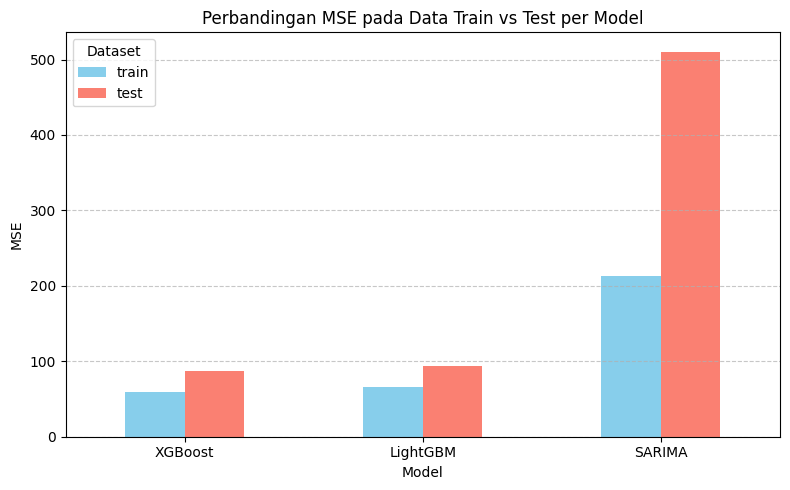

In [28]:
# Plot vertikal
ax = mse.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'], rot=0)
plt.title('Perbandingan MSE pada Data Train vs Test per Model')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

**Insight**: XGBoost memiliki nilai error paling kecil, maka dipilih sebagai model terbaik untuk memprediksi volume lalu lintas

In [29]:
# Menguji Prediksi
prediksi = X_test.iloc[:1].copy()
pred_dict = {'y_true': y_test[:1]}
for name, model in model_dict.items():
    pred_dict['prediksi_' + name] = model.predict(prediksi).round()

# Menambahkan SARIMA
pred_date = prediksi.index[0].floor('D')
sarimax_pred_value = sarimax_fit.predict(start=pred_date, end=pred_date, exog=exog.loc[[pred_date]])
pred_dict['prediksi_SARIMAX'] = sarimax_pred_value.values.round()

tabel = pd.DataFrame(pred_dict)
display(tabel)

,y_true,prediksi_XGBoost,prediksi_LightGBM,prediksi_SARIMAX
date_time,,,,
2015-12-01 16:00:00,6376,5181.0,4982.0,3251.0


**Insight**: Model XGBoost memberi prediksi yang paling mendekati nilai sesungguhnya